In [2]:
import tensorflow as tf
import mplfinance as mpf
import tensorflow.keras as keras
import tensorflow.keras.utils as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import datetime

In [3]:
csvFileAddress = input('csv file address') 

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ.drop(['<VOL>'],axis=1,inplace=True)


timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) ) * 60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)
timeFrame
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]

newnumparr = np.full((uniqueDaysCount*CandlesInDay,2),'',dtype=np.object_)


for i in range(uniqueDaysCount):
    for j in range(CandlesInDay):
        newnumparr[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j)]

newDF = pd.DataFrame(newnumparr,columns=['<DATE>','<TIME>'])

newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

newestDF.fillna(0,inplace=True)

uniqueDaysCount

newestDF.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<SPREAD>
0,2018.01.22,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2018.01.22,00:05:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2018.01.22,00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2018.01.22,00:15:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2018.01.22,00:20:00,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
timeFrame = (int(newestDF.iloc[1]['<TIME>'][1])-int(newestDF.iloc[0]['<TIME>'][1]) ) * 60 + (int(newestDF.iloc[1]['<TIME>'][3:5])-int(newestDF.iloc[0]['<TIME>'][3:5]))
CandlesInDay = 24 * (60//timeFrame)
uniqueDaysCount = len(newestDF)//CandlesInDay

In [40]:
startCandleHour = 9.5
startCandleIndex = int(startCandleHour * CandlesInDay )// 24

windowLengthHour = 2
windowLengthCount = int(windowLengthHour * CandlesInDay) // 24


labelStartCandleHour = startCandleHour+windowLengthHour
labelStartCandleIndex = int(labelStartCandleHour * CandlesInDay) // 24

labelWindowLengthHour = 4
labelWindowLengthCount = int(labelWindowLengthHour * CandlesInDay) // 24


In [41]:
SLTP = .003
takeProfitPoints = 1+SLTP
stopLoss = 1-SLTP

df = newestDF.drop(['<DATE>'],axis=1)

trainNPs = []
labelsDFs = []
labelValues = []
trainDFs = []

maxValues = df.max()

for i in range(0,len(df)-CandlesInDay , CandlesInDay):
    trainDF = df.iloc[i+startCandleIndex : (i+startCandleIndex +windowLengthCount)]
    labelDF = df.iloc[i+labelStartCandleIndex :(i+labelStartCandleIndex+labelWindowLengthCount) ]

    lowestIndex = labelDF['<LOW>'].idxmin()
    lowestPriceInLabels = labelDF['<LOW>'][lowestIndex]

    highesIndex = labelDF['<HIGH>'].idxmax()
    highestPriceInLabels = labelDF['<HIGH>'][highesIndex]

    TP = labelDF['<OPEN>'].iloc[0]*takeProfitPoints
    SL = labelDF['<OPEN>'].iloc[0]*stopLoss

    buySignal = 0

    if highestPriceInLabels < TP and lowestPriceInLabels > SL:
        # ideas : halfTP
        buySignal=2
        
    elif highestPriceInLabels < TP and lowestPriceInLabels < SL:
        buySignal = 0
    elif highestPriceInLabels > TP and lowestPriceInLabels > SL:
        buySignal = 1
    else :
        tpIndex = 0
        slIndex = 0
        for j in range(len(labelDF)):
            if labelDF['<HIGH>'].iloc[j] > TP and labelDF['<LOW>'].iloc[j]>SL :
                tpIndex=j
            if labelDF['<HIGH>'].iloc[j] < TP and labelDF['<LOW>'].iloc[j]>SL :
                continue
            if labelDF['<HIGH>'].iloc[j] < TP and labelDF['<LOW>'].iloc[j]<SL :
                slIndex=j
        buySignal = int(tpIndex<slIndex)
        if slIndex==tpIndex:
            buySignal=2
    

    # trainDF =  trainDF /df.abs().max()

    # trainDF = trainDF.drop(['<OPEN>','<ATR_24>','<EMA30>','<RSI>','<CCI>','<KELTNER_M>','<KELTNER_L>','<KELTNER_H>','<GREEN>'],axis=1)
    trainDFColumnsArr = ['<TIME>','<LOW>','<HIGH>','<OPEN>','<CLOSE>','<TICKVOL>']
    trainDFColumnsExcludeTime = trainDFColumnsArr[1:]
    
    trainDF = trainDF[trainDFColumnsArr]
    trainDF['<TIME>']=pd.to_datetime(trainDF['<TIME>'],infer_datetime_format=1)



    # trainDF[trainDFColumnsExcludeTime]=(trainDF[trainDFColumnsExcludeTime]-df[trainDFColumnsExcludeTime].min())/(df[trainDFColumnsExcludeTime].max()-df[trainDFColumnsExcludeTime].min())
    
    trainNp =(trainDF.to_numpy(dtype=np.float32))
    # trainNp = np.rot90( trainDF.to_numpy())


    labelValues.append(buySignal)
    trainNPs.append(trainNp)
    trainDFs.append(trainDF)
    labelsDFs.append(labelDF)


In [42]:
len(trainDFs),len(labelValues)

(1117, 1117)

In [43]:
pd.DataFrame(labelValues,columns=['signal']).value_counts()

signal
1         521
0         488
2         108
dtype: int64

In [9]:
# tempDF = trainDFs[5]
# tempLabel = labelValues[5]
# tempDF.columns=['Datetime','Low','High','Open','Close','Volume']


# mpf.plot(tempDF.set_index('Datetime',),type='candle',volume=True,figsize=(5,5),axisoff=True)


In [51]:
import io
import gc
trainData = []
for i in range(len(trainDFs)):
    if i%100 == 0:
        print(i)
    tempDF = trainDFs[i]
    tempLabel = labelValues[i]
    tempDF.columns=['Datetime','Low','High','Open','Close','Volume']
    with io.BytesIO() as buf:
        keras.backend.clear_session()
        fig,ax = mpf.plot(tempDF.set_index('Datetime',),returnfig=True,type='candle',figsize=(2.24,2.24),savefig=buf,axisoff=True)
        
        buf.seek(0)
        data = buf.read()
        with tf.device('/CPU:0'): 
            trainData.append(tf.io.decode_png(data,3).numpy())
        buf.seek(0)
        buf.truncate()
        buf.flush()
        buf.close()
        plt.close()
    
gc.collect()



0
100
200
300
400
500
600
700
800
900
1000
1100


2453

In [ ]:
# trainDFs[7]

In [67]:
# mpf.kwarg_help('plot')

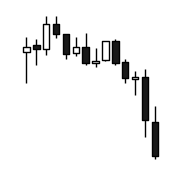

In [70]:
mpf.plot(tempDF.set_index('Datetime',),mav=(),type='candle',figsize=(2.24,2.24),axisoff=True)

In [46]:
len(trainData),len(labelValues)

(1117, 1117)

In [52]:

trainData,valData = trainData[:int(.8*len(trainData))],trainData[int(.8*len(trainData))+1:]
trainLables,valLabels = labelValues[:int(.8*len(labelValues))],labelValues[int(.8*len(labelValues))+1:]

In [64]:
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

tf.random.set_seed(42)

model = keras.Sequential([
    Conv2D(50,4,input_shape=trainData[0].shape,activation='relu'),
    Conv2D(50,4,activation='relu'),
    MaxPooling2D(3,padding='same'),
    Conv2D(50,4,activation='relu'),
    Conv2D(50,4,activation='relu'),
    MaxPooling2D(2,padding='same'),
    Conv2D(50,4,activation='relu'),
    Conv2D(50,4,activation='relu'),
    MaxPooling2D(2,padding='same'),
    Conv2D(50,4,activation='relu'),
    Conv2D(50,4,activation='relu'),
    MaxPooling2D(2,padding='same'),
    Flatten(),
    Dense(50,activation='relu'),
    Dense(50,activation='relu'),
    Dense(3,activation='sigmoid'),
])

# model.summary()

model.compile(
            loss=keras.losses.sparse_categorical_crossentropy,
            optimizer = keras.optimizers.Adam(learning_rate=.006),
            metrics=['accuracy']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 221, 221, 50)      2450      
                                                                 
 conv2d_41 (Conv2D)          (None, 218, 218, 50)      40050     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 73, 73, 50)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 70, 70, 50)        40050     
                                                                 
 conv2d_43 (Conv2D)          (None, 67, 67, 50)        40050     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 34, 34, 50)       0         
 g2D)                                                 

9598006

In [ ]:
gc.collect()

trainData = np.asarray(trainData)
trainLables = np.asarray(trainLables)
valData = np.asarray(valData)
valLabels = np.asarray(valLabels)


model.fit(trainData,trainLables,batch_size=32,epochs=10,validation_data=(valData,valLabels),verbose=2,)